<a href="https://colab.research.google.com/github/Densadam/Titanic_Predict/blob/main/Titanic_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Notebook shows data of passengers who were aboard the Titanic when it sank. This was created to show the process to explore the data, clean up any missing data and finaly create a prediction model which tries to predict if a passenger would survive the sinking of the ship or not. 

The original dataset can be found here:
https://www.kaggle.com/competitions/titanic/data

Created by Adam Densley

In [1]:
# Imports necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(style='whitegrid')
%matplotlib inline
import io
import re
import requests
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from pandas.core.computation.parsing import clean_column_name
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
# Imports then prints datasets gathered from my github site

# Imports training dataset which will be used to create predictive model
url = 'https://raw.githubusercontent.com/Densadam/Titanic_Predict/master/train.csv'
response = requests.get(url)
train_data = pd.read_csv(io.StringIO(response.text))

# This imports test dataset which is missing the 'Survived' column and what our prediction model will try to fill
url = 'https://raw.githubusercontent.com/Densadam/Titanic_Predict/master/test.csv'
response = requests.get(url)
test_data = pd.read_csv(io.StringIO(response.text))

# Show the first 5 rows of train.csv content
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Note there is some missing data (NaN). I'll address this later, I want to look over the existing data first. 

<ipython-input-3-8a2d5818a02d>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_data.corr(), cmap='viridis')


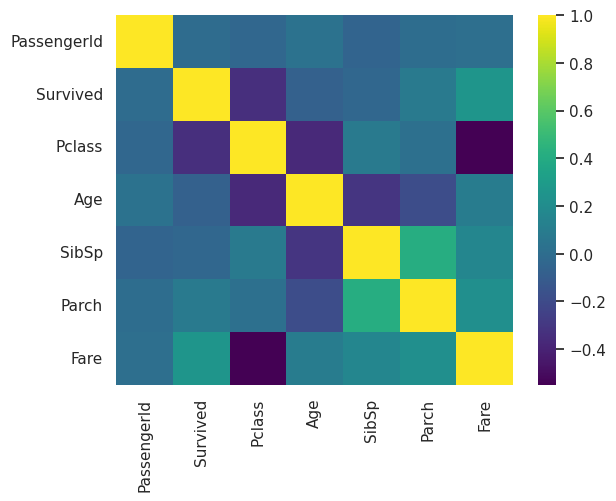

In [3]:
# Shows a heatmap of correlations between each column

sns.heatmap(train_data.corr(), cmap='viridis')
plt.show()

This graph shows how correlated each column is to one another. The further away from 0 (positive or negative) will indicate more relation to survival. Perfect examples are the 'Pclass' (passenger class) and 'Fare' (fare passenger paid) compared to 'Survived'. 

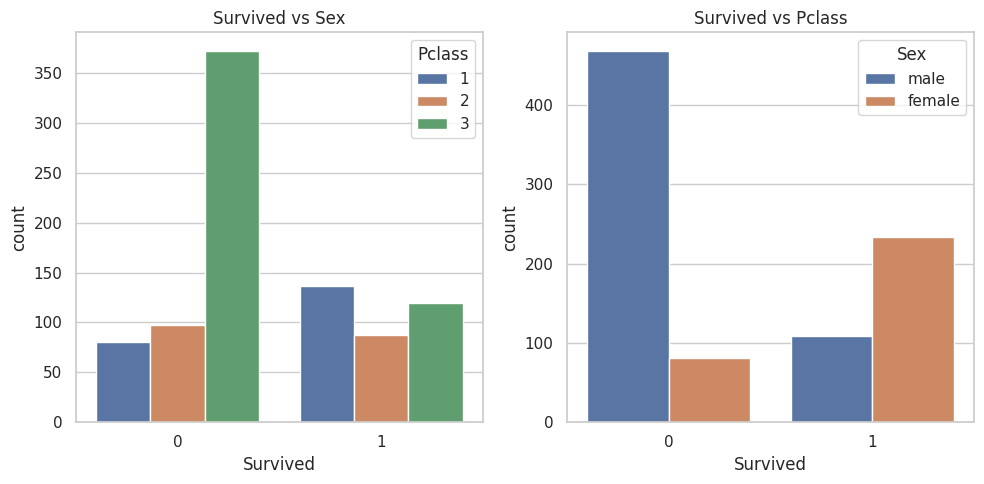

In [4]:
# Compares passengers who survived and their sex and pclass

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(x='Survived', hue='Sex', data=train_data, ax=axes[1])
axes[0].set_title('Survived vs Sex')

sns.countplot(x='Survived', hue='Pclass', data=train_data, ax=axes[0])
axes[1].set_title('Survived vs Pclass')

plt.tight_layout()
plt.show()

The '0' value represents that passenger didn't survive. Note the significantly higher fatality count for men and 3rd class passengers.

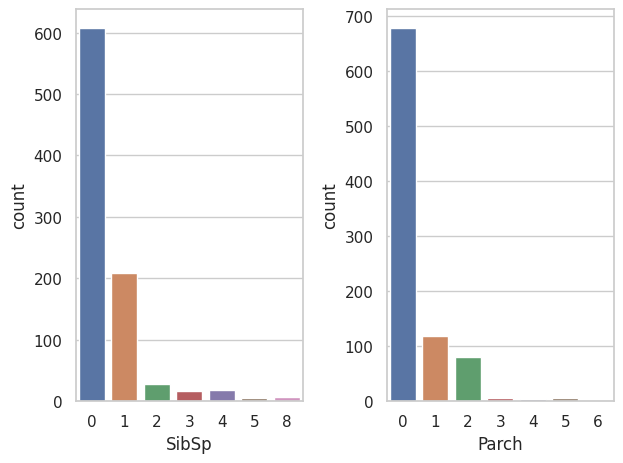

In [5]:
# Counts the number of spouce/siblings and parrents/children onboard

# Shows Sibling/Spouce count
plt.subplot(1, 2, 1) 
sns.countplot(x='SibSp', data=train_data)

# Shows Parrent/Children count
plt.subplot(1, 2, 2)
sns.countplot(x='Parch', data=train_data)

plt.tight_layout()
plt.show()


Most passengers didn't have siblings/spouses or parents/children traveling with them. I suspect that passengers who are traveling with family may have a greater chance of survival. I'll turn this into a feature later. 

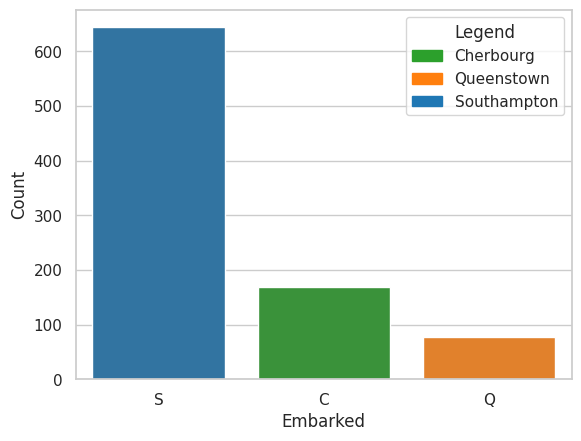

In [6]:
# Visualizes the quantity of passengers who embarked from each port

palette = {'S': 'tab:blue', 'C': 'tab:green', 'Q': 'tab:orange'}
legend_labels = {'C': 'Cherbourg', 'Q': 'Queenstown', 'S': 'Southampton'}

ax = sns.countplot(x='Embarked', data=train_data, palette=palette.values())
handles = [plt.Rectangle((0, 0), 1, 1, color=palette[label]) for label in legend_labels.keys()]

plt.xlabel('Embarked')
plt.ylabel('Count')
plt.legend(handles=handles, labels=legend_labels.values(), title='Legend')
plt.show()

A majority of passengers embarked at 'S' or  the port of "Southampton"

<Axes: ylabel='Frequency'>

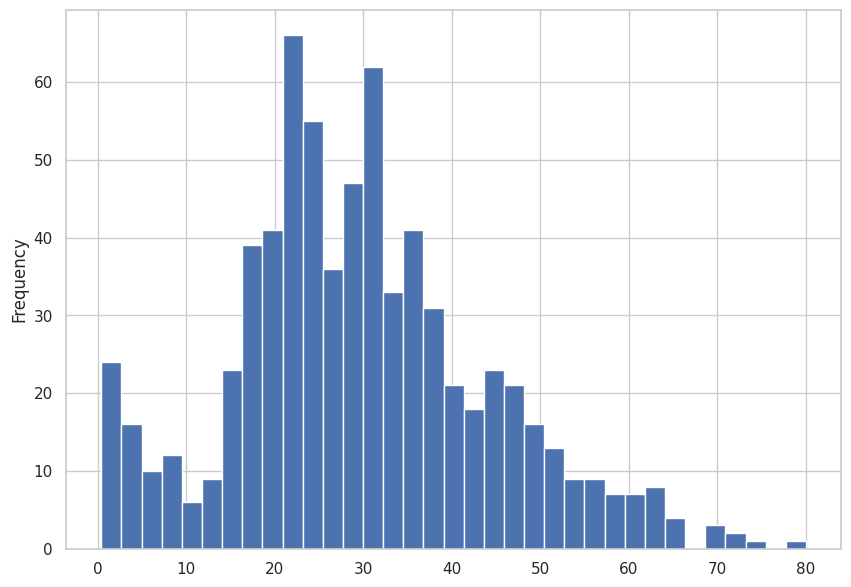

In [7]:
# Shows the age count of passengers

plt.figure(figsize=(10,7))
train_data['Age'].plot.hist(bins=35)

Most passengers are between the ages of 20 and 40

<Axes: xlabel='Pclass', ylabel='Age'>

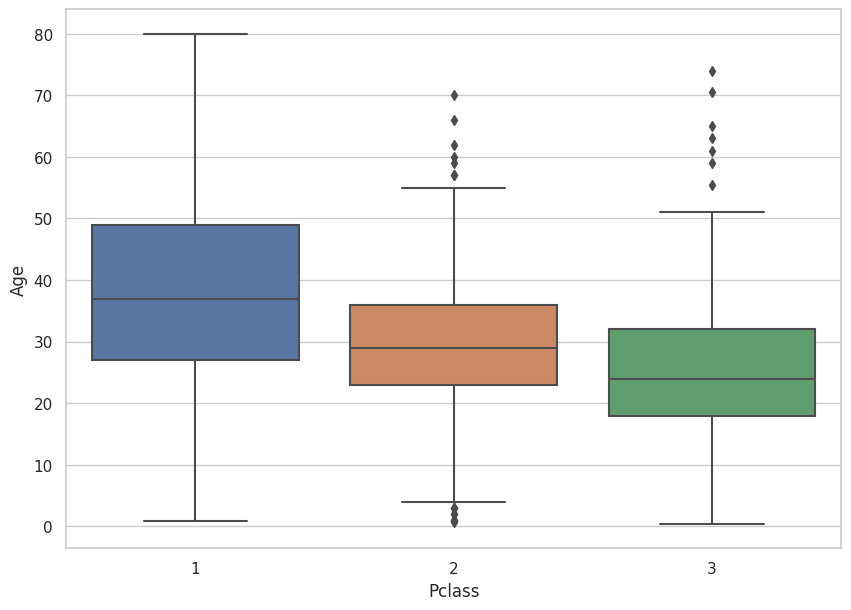

In [8]:
# Shows visual of the average age of passengers based on passenger class

plt.figure(figsize=(10,7))
sns.boxplot(x='Pclass',y='Age', data=train_data)

This chart shows the average passenger age based on their class. Note how passengers in upper class tend to be older. 

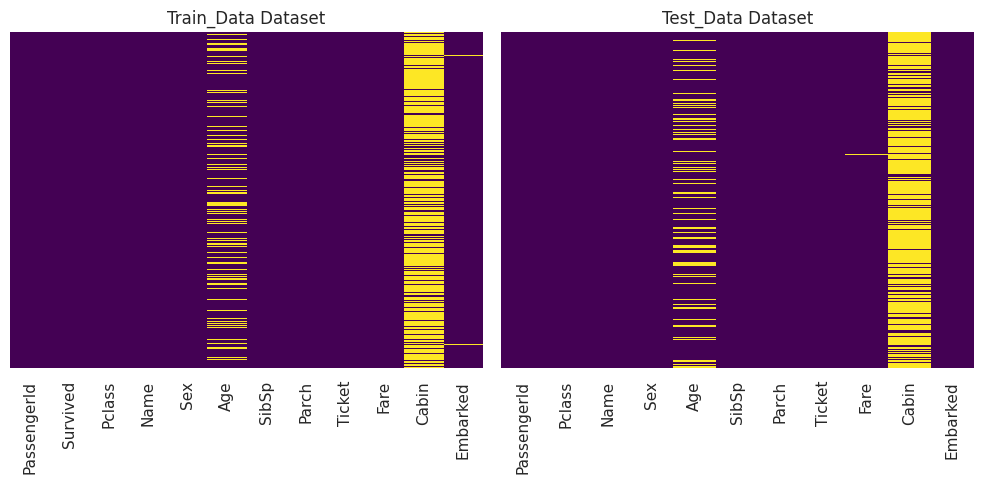

In [9]:
# This will return a graph showing a heat map of null values in 'train_data' and 'test_data'

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first heatmap for train data
sns.heatmap(train_data.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=axes[0])
axes[0].set_title('Train_Data Dataset')

# Plot the second heatmap for test data
sns.heatmap(test_data.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=axes[1])
axes[1].set_title('Test_Data Dataset')

plt.tight_layout()  # Adjust the layout for better spacing
plt.show()

The missing data in each dataset is displayed in 'yellow'

In [10]:
# Returns row count as well as null and duplicate values for both 'train_data' and 'test_data' datasets

def data_summary(train_data, test_data):
    # Check for Null values
    print('\nNull Values in Train_Data: \n{}'.format(train_data.isnull().sum()))
    print('\nNull Values in Test_Data: \n{}'.format(test_data.isnull().sum()))

    # Check for Duplicates
    print('\nDuplicated values in the Train_Data: {}'.format(train_data.duplicated().sum()))
    print('Duplicated values in the Test_Data: {}'.format(test_data.duplicated().sum()))

    # Return Row count
    print('Total Rows in Train_Data: {}'.format(train_data.shape[0]))
    print('Total Rows in Test_Data: {}'.format(test_data.shape[0]))

data_summary(train_data, test_data)


Null Values in Train_Data: 
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Null Values in Test_Data: 
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Duplicated values in the Train_Data: 0
Duplicated values in the Test_Data: 0
Total Rows in Train_Data: 891
Total Rows in Test_Data: 418


There's missing data in the 'Age' and 'Cabin' columns. Only the 'train_data' dataset is missing data in the 'Embarked' column. Only the 'test_data' dataset is missing data in the 'Fare' column.

In [11]:
# Assigns all NaN values in 'Embarked' column with 'S'

train_data['Embarked'].fillna(value='S', inplace=True)

I wanted to address the missing 'Embarked' data in the 'train_data' dataset. There's only 2 rows of missing data. From my previous observation, I can see that 'Southampton' ('S') was the most common and likely port to embark from. 

In [12]:
# Fills in missing fare value in 'test' dataest with the average fare value

test_data['Fare'].fillna(value=test_data.Fare.mean(), inplace=True)

There was also only 1 Fare that was missing from the 'test_data' dataset. I applied the average fare value to the missing data.

I want to start by performing a split on the 'train_data' dataset to start preparing for the data pipeline. The stratified shuffle split is useful when working with uneven datasets.

In [13]:
# Performs stratified shuffle split on the 'train_data' dataset.

split= StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
for train_indices, test_indices in split.split(train_data, train_data[['Survived', 'Pclass', 'Sex']]):
  strat_train = train_data.loc[train_indices]
  strat_test = train_data.loc[test_indices]

In [14]:
# Count the number of missing values in 'Cabin' column

missing_values_count = train_data['Cabin'].isnull().sum()
total_rows = len(train_data)
percentage_missing = (missing_values_count / total_rows) * 100
print(f"Percentage of missing values in 'Cabin' column: {percentage_missing:.2f}%")

Percentage of missing values in 'Cabin' column: 77.10%


With this much missing data in the 'Cabin' column, I would have to infer too much data if I wanted to rebuild it. This would also likely throw off our predictions if I tried to rebuild the data. I will drop this later.

In [15]:
# Returns the median passenger age based on their class

median_age_train = train_data.groupby('Pclass')['Age'].mean()
print(median_age_train)

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64


This returns the mean age of the passengers based on their passenger class which is used in the following class

In [16]:
# Assigns missing data in the 'Age' column with infered data based on passenger class and mean age

class AgeImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
  
    def transform(self, X):
        def assign_age(cols):
            Age = cols[0]
            Pclass = cols[1]

            if pd.isnull(Age):
                if Pclass == 1:
                    return 38.233441
                elif Pclass == 2:
                    return 29.877630
                else:
                    return 25.140620
            else:
                return Age

        X['Age'] = X[['Age', 'Pclass']].apply(assign_age, axis=1)
        imputer = SimpleImputer(strategy='mean')
        X['Age'] = imputer.fit_transform(X[['Age']])
        return X

In [17]:
# Creates new columns based on the 'Sex', 'Embark'. Assigns number based on the passenger's 'Title' and checks if passenger likely traveling 'Alone' or is a minor (['is_minor'])

class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        encoder = OneHotEncoder()
        matrix_embarked = encoder.fit_transform(X[['Embarked']]).toarray()
        column_names_embarked = ['C', 'S', 'Q', 'N']

        for i in range(len(matrix_embarked.T)):
            X[column_names_embarked[i]] = matrix_embarked.T[i]
        
        matrix_sex = encoder.fit_transform(X[['Sex']]).toarray()
        column_names_sex = ['Female', 'Male']

        for i in range(len(matrix_sex.T)):
            X[column_names_sex[i]] = matrix_sex.T[i]
        
        X['Alone'] = X['SibSp'] + X['Parch']
        X['Alone'] = np.where(X['Alone'] > 0, 0, 1)
        
        X['Minor'] = np.where(X['Age'] <= 16, 1, 0)
        
        return X

In [18]:
# Drops any columns no longer needed

class FeatureDropper(BaseEstimator, TransformerMixin):

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    return X.drop(['Embarked', 'Name', 'Ticket', 'Cabin', 'Sex'], axis=1)

In [19]:
# Creates pipeline which applies previous class directed changes to any future datasets (like the 'test' dataset)

pipeline = Pipeline([
    ('ageimputer', AgeImputer()),
    ('featureencoder', FeatureEncoder()),
    ('featuredropper', FeatureDropper())                    
])

# Fits pipeline to the 'strat_train' split data
strat_train = pipeline.fit_transform(strat_train)
strat_train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male,Alone,Minor
873,874,0,3,47.00000,0,0,9.0000,0.0,0.0,1.0,0.0,1.0,1,0
858,859,1,3,24.00000,0,3,19.2583,1.0,0.0,0.0,1.0,0.0,0,0
565,566,0,3,24.00000,2,0,24.1500,0.0,0.0,1.0,0.0,1.0,0,0
641,642,1,1,24.00000,0,0,69.3000,1.0,0.0,0.0,1.0,0.0,1,0
783,784,0,3,25.14062,1,2,23.4500,0.0,0.0,1.0,0.0,1.0,0,0


Note the columns consist of numeric values which makes it easier to input into model

In [20]:
# Seperates data into testing data and training data

X = strat_train.drop(['Survived'], axis=1)
y = strat_train['Survived']

scaler = StandardScaler()
X_data = scaler.fit_transform(X)
y_data = y.to_numpy()

In [21]:
# Runs model through all different configurations in order to determine optimal configuration to be used for prediction model.
# Note that running this process can take a few minutes to complete.

model = RandomForestClassifier()

param_grid = [
    {'n_estimators': [10, 100, 200, 500, 1000], 'max_depth': [None, 5, 10, 15], 'min_samples_split': [2, 3, 4, 5]}
]

grid_search = GridSearchCV(model, param_grid, cv=split, scoring='accuracy', return_train_score=True)
grid_search.fit(X_data, y_data)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
             estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10, 15],
                          'min_samples_split': [2, 3, 4, 5],
                          'n_estimators': [10, 100, 200, 500, 1000]}],
             return_train_score=True, scoring='accuracy')

In [22]:
# Shows results of optimal settings

optimized_model = grid_search.best_estimator_
optimized_model

RandomForestClassifier(max_depth=10, min_samples_split=4, n_estimators=200)

In [23]:
# Inputs test data (from 'train_data') into pipeline to transform/fit it into model

strat_test = pipeline.fit_transform(strat_test)

X_test = strat_test.drop(['Survived'], axis=1)
y_test = strat_test['Survived']

scaler = StandardScaler()
X_data_test = scaler.fit_transform(X_test)
y_data_test = y_test.to_numpy()

In [24]:
# Returns accuracy score of how well model performed

optimized_model.score(X_data_test, y_data_test)

0.8324022346368715

In [25]:
# Repeating steps to implement model on the 'train_data' 

final_data = pipeline.fit_transform(train_data)

X_final = final_data.drop(['Survived'], axis=1)
y_final = final_data['Survived']

scaler = StandardScaler()
X_data_final = scaler.fit_transform(X_final)
y_data_final = y_final.to_numpy()

In [26]:
prod_model = RandomForestClassifier()

param_grid = [
    {'n_estimators': [10, 100, 200, 500, 1000], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 3, 4]}
]

grid_search = GridSearchCV(prod_model, param_grid, cv=split, scoring='accuracy', return_train_score=True)
grid_search.fit(X_data_final, y_data_final)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
             estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500, 1000]}],
             return_train_score=True, scoring='accuracy')

In [37]:
prod_final_model = grid_search.best_estimator_
prod_final_model

RandomForestClassifier(min_samples_split=4, n_estimators=500)

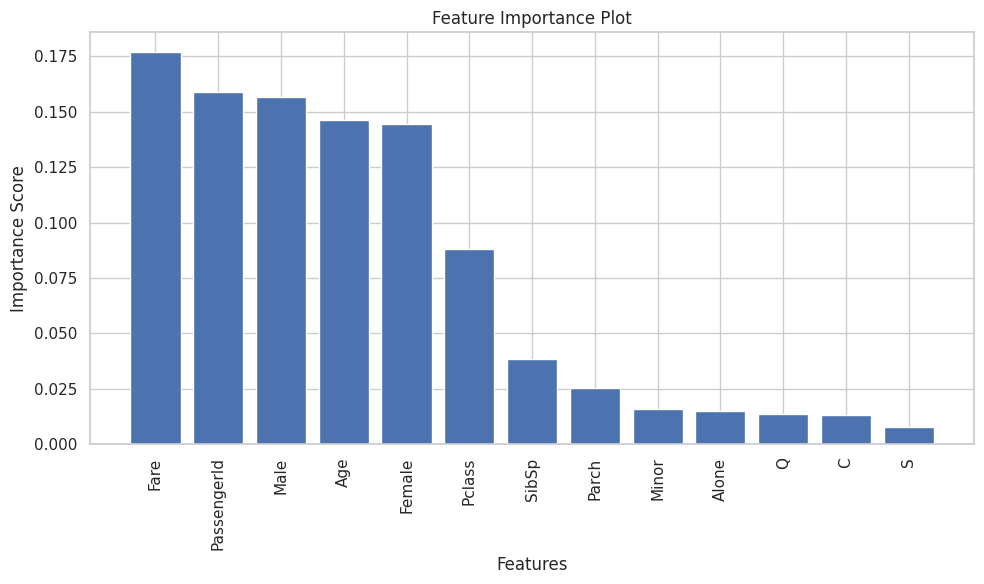

In [28]:
# Retrieve feature importance from the model

importances = prod_final_model.feature_importances_
features = X_final.columns

# Sort the features based on their importance scores
indices = np.argsort(importances)[::-1]
sorted_features = [features[i] for i in indices]
sorted_importances = importances[indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(features)), sorted_importances)
plt.xticks(range(len(features)), sorted_features, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importance Plot')
plt.tight_layout()
plt.show()

This graph shows how important/influential a column is in determining if a passenger survived or not. 

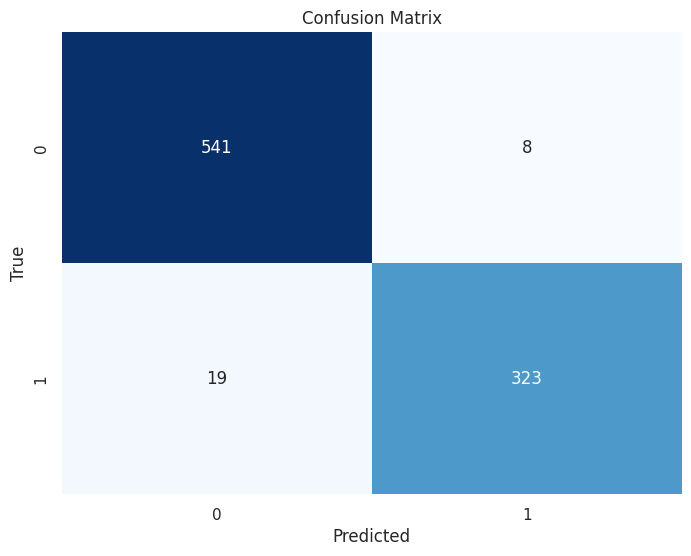

In [39]:
# Shows confusion maxtrix 

predictions = prod_final_model.predict(X_data_final)
cm = confusion_matrix(y_data_final, predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

This Confusion Matrix represents the model's performance (True Possitive, True Negative, False Possitive, False Negative).

In [30]:
# Returns accuracy score of how well model performed

prod_final_model.score(X_data_final, y_data_final)

0.9696969696969697

In [31]:
# Applies pipline/model to 'test_data'

final_test_data = pipeline.fit_transform(test_data)

In [32]:
X_final_test = final_test_data
X_final_test = X_final_test.fillna(method='ffill')

scaler = StandardScaler()
X_data_final_test = scaler.fit_transform(X_final_test)

In [33]:
predictions = prod_final_model.predict(X_data_final_test)

In [34]:
# Returns survival predictions on 'test_data'

test_prediction_preview = test_data[['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']]
test_prediction_preview = test_prediction_preview.assign(Survived=predictions)
test_prediction_preview = test_prediction_preview.reindex(columns=['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'])

test_prediction_preview

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.50000,0,0,330911,7.8292,NaN,Q
1,893,0,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00000,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.00000,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.00000,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00000,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,0,3,"Spector, Mr. Woolf",male,25.14062,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,1,"Oliva y Ocana, Dona. Fermina",female,39.00000,0,0,PC 17758,108.9000,C105,C
415,1307,0,3,"Saether, Mr. Simon Sivertsen",male,38.50000,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,0,3,"Ware, Mr. Frederick",male,25.14062,0,0,359309,8.0500,NaN,S


This shows the predicted values in which passengers survived.

In [36]:
# Optional: Sets up and creates csv file ready for submition to Kaggle

final_df = pd.DataFrame(test_data['PassengerId'])
final_df['Survived'] = predictions
final_df.to_csv('submission.csv', index=False)